### Import necessary packages

In [1]:
from fastai.vision.all import * 
from fastai.torch_core import TensorBase
import torchvision.models as torchModels
import pathlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torchvision.transforms as T
import tifffile as tiff
import matplotlib as mp
import numpy as np
import cv2

torch.manual_seed(0) 
random.seed(0)

# Checking the device compatibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # to select device as cpu only put this torch.device('cpu') 
print('Using device:', device)
#print(torch.cuda.get_device_name(0))
#print(torch.__version__)


Using device: cuda


### Initialize the path directories

#### Requirements: The images were sorted as one tiff image i.e. the 7 channels were hyperstacked into it and stored in the 'hyperstack' subfolder. The corresponding ground truth was stored in the 'mask' subfolder. 
Note: All the images were saved in 8 bit format and the ground truth image values should be 0 and 1. (refer sort_data.ipynb)

In [2]:
# Replace with your path directory
path = Path('/home/susa03/post_project/post_dataset/synthetic_data/sorted_data/') 
path_images = path/'hyperstack'
file_names = get_image_files(path_images)
path_labels = path/'masks'
label_names = get_image_files(path_labels)

### Define custom datablock for N>3 channel input

In [3]:
def get_x_multi(filename):
    return filename

def get_y(filename):
    return (path_labels / Path(filename.stem + filename.suffix ))

class TensorLoad(Transform):
    def __init__(self):
        pass

    def encodes(self, x):
        filename = x
        img = tiff.imread(filename) 
        imgtest = torch.from_numpy(img)
        imgtest = imgtest.type(torch.FloatTensor)
        return imgtest 

def TensorBlock():
    return TransformBlock(type_tfms=TensorLoad, 
                          batch_tfms=IntToFloatTensor,
                          
                          )

class ResizeItem(Transform):
    def __init__(self,size):
        self.size = size        

    def encodes(self, x):
        if len(x.shape)==3:
            num_channels = x.shape[0]
            tensor_resized = torch.empty(num_channels,self.size,self.size)
            transform = T.Resize((self.size,self.size),)
            for channel_no in range(num_channels):
                frame_current = x[channel_no,:,:]
                frame_current = frame_current[None,:]
                resized_frame = transform(frame_current)
                tensor_resized[channel_no,:,:] = resized_frame
        else:
            transform = T.Resize((self.size,self.size),)
            frame_current = x
            tensor_resized = (transform(frame_current))   
        return tensor_resized 
    
def show_results(pred_samples,target):
    total_samples = target.shape[0]
    
    sample_no = np.random.randint(0,total_samples,1)
    target = target[sample_no[0],:,:]
    
    channel_0 = pred_samples[sample_no,0,:,:]
    channel_0[channel_0>0.5] = 1
    channel_0[channel_0<=0.5] = 0

    channel_1 = pred_samples[sample_no,1,:,:]
    channel_1[channel_1>0.5] = 1
    channel_1[channel_1<=0.5] = 0

    prediction = channel_1 * (1-channel_0)
    prediction = torch.squeeze(prediction)
    
    # Calculate true positives, true negatives, false positives, and false negatives
    tp = torch.sum((prediction == 1) & (target == 1)).item()
    tn = torch.sum((prediction == 0) & (target == 0)).item()
    fp = torch.sum((prediction == 1) & (target == 0)).item()
    fn = torch.sum((prediction == 0) & (target == 1)).item()
    
    accuracy = ((tp + tn) / (tp+tn+fp+fn)) 
    #print(f'Accuracy = {accuracy* 100}%')
    
    fig,(ax1,ax2,ax3) = plt.subplots(1,3)
    
    ax1.imshow(target)
    ax1.set_title('Target')
    ax1.axis('off')
    
    ax2.imshow(prediction)  
    ax2.set_title('Prediction')
    ax2.axis('off')
    
    # Calculate false positives and false negatives
    false_positives = np.array(np.logical_and(prediction == 1, target == 0))
    false_negatives = np.array(np.logical_and(prediction == 0, target == 1))

    # Visualize segmentation with false positives (red) and false negatives (blue)
    visualization = np.zeros(prediction.shape + (3,))
    visualization[prediction == 1] = [0, 0.5, 0]  # True positives (green)
    visualization[false_positives==True] = [1, 1, 0]  # False positives (yellow)
    visualization[false_negatives==True] = [1, 0, 0]  # False negatives (red)
    
    # Define the colors for the colorbar
    colors = [(1,0,0),(0,0.5,0),(1,1,0)]  # Red, Green, yellow

    # Define the corresponding values for the colors
    values = [0, 0.5, 1]  

    # Define the names for the colors
    resp_names = ['FN', 'TP', 'FP']

    # Create a custom colormap using the colors and values
    cmap = LinearSegmentedColormap.from_list('CustomColorbar', list(zip(values, colors)),N=3) 
    
    im = ax3.imshow((visualization))
    ax3.set_title('Accuracy map')
    ax3.axis('off')
    
    # Create a separate axis for the colorbar
    cbar_ax = fig.add_axes([0.92, 0.35, 0.02, 0.3]) 

    # Plot a colorbar using the custom colormap and color names
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap),cax=cbar_ax)
    cbar.set_ticks(values)
    cbar.set_ticklabels(resp_names)

### Loading the data

In [4]:
# Label output mask for maskblock implementation
codes = np.array(['background','porus'])
splitter =  TrainTestSplitter (test_size=0.2, random_state=None, stratify=None,train_size=None, shuffle=True)
batchSize = 2
img_size = 850
datablocks = DataBlock(blocks=(TensorBlock, MaskBlock(codes)),
                       get_items = get_image_files,
                       get_x = get_x_multi,
                       get_y = get_y,
                       splitter=splitter,
                       item_tfms=ResizeItem(img_size), 
                       )

data_loader = datablocks.dataloaders(path_images, bs=batchSize,device=device )

/home/susa03/post_project/unet_fastai/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### Define evaluation metrics

In [5]:
#Calculate the proportion of correct predictions
def original_ac(predictions, target):
    pred_hot1_decoded = predictions.argmax(dim=1)
    correct_predictions = ( TensorBase(pred_hot1_decoded) == TensorBase(target) )
    correct_predictions = correct_predictions.float()
    return correct_predictions.mean()

#Number of correctly determined porus pixels divided by number of all porus pixels
def porus_ac(predictions, target):   
    pred_hot1_decoded = predictions.argmax(dim=1)
    porosity_in_target = target == 1
    correct_porosity = torch.logical_and( TensorBase(porosity_in_target), TensorBase(pred_hot1_decoded) )
    correct_porosity = correct_porosity.float()       
    return correct_porosity.sum() / porosity_in_target.float().sum()

metrics = [porus_ac, original_ac]

### Choose a suitable architechture as learner

In [6]:
#learner = unet_learner(data_loader, torchModels.vgg16_bn, metrics = metrics,n_in=7,)
#learner = unet_learner(data_loader, resnet18, metrics = metrics,n_in=7,n_out=1,loss_func=CrossEntropyLossFlat(flatten=True))
learner = unet_learner(data_loader, resnet34, metrics = metrics,n_in=7)
learner.loss_func

/home/susa03/post_project/unet_fastai/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/susa03/post_project/unet_fastai/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FlattenedLoss of CrossEntropyLoss()

### Architechture summary

In [7]:
print(learner.summary())

DynamicUnet (Input shape: 2 x 7 x 850 x 850)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 64 x 425 x 425  
Conv2d                                    21952      False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     2 x 64 x 213 x 213  
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

### Find the appropriate learning rate

Message: Learning rate selected is: 6.30957365501672e-05


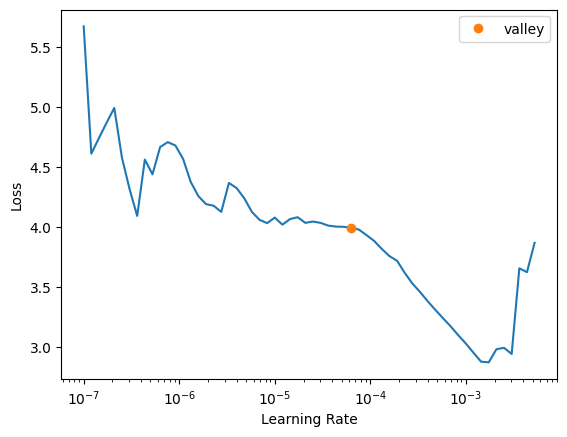

In [8]:
l_r = learner.lr_find()
learning_rate = l_r.valley
print(f"Message: Learning rate selected is: {learning_rate}")

### Save the learner

In [9]:
learner.save("model_hyperstack")

Path('models/model_hyperstack.pth')

### Load the learner and train the network 

epoch,train_loss,valid_loss,porus_ac,original_ac,time
0,0.186663,0.152434,0.934732,0.953522,04:47
1,0.075890,0.052750,0.981030,0.982526,04:48
2,0.035305,0.032689,0.990140,0.988945,04:47
3,0.025937,0.026279,0.994564,0.991069,04:47
4,0.024039,0.024700,0.993913,0.991675,04:48


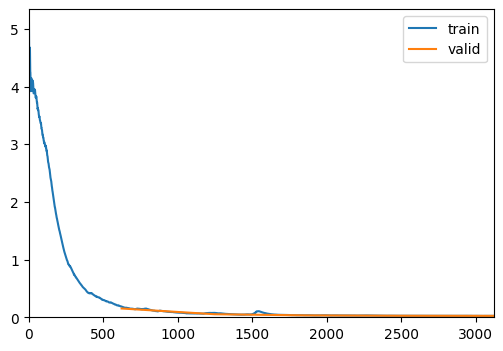

In [11]:
learner.load("model_hyperstack")
epochs = 5
learner.fit_one_cycle(epochs, slice(learning_rate), cbs=[ShowGraphCallback()])

### Export the model along with training weights

In [12]:
learner.export("model_hyperstack.pkl")

### Prediction based on learning

In [13]:
input_img,preds,ground_truth,losses = learner.get_preds(with_loss=True,with_input=True)

/home/susa03/post_project/unet_fastai/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/susa03/post_project/unet_fastai/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change fro

### Show the results

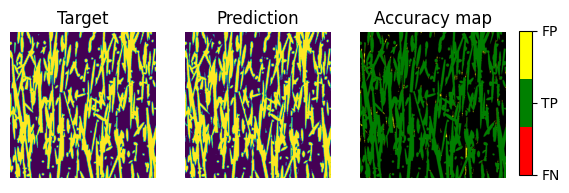

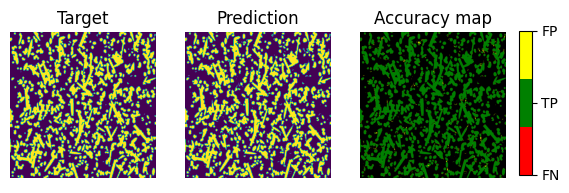

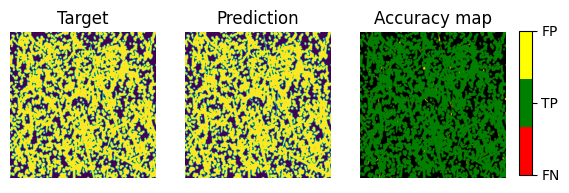

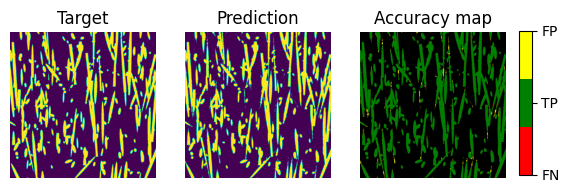

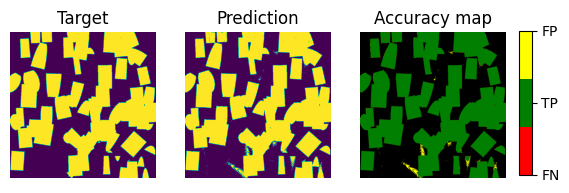

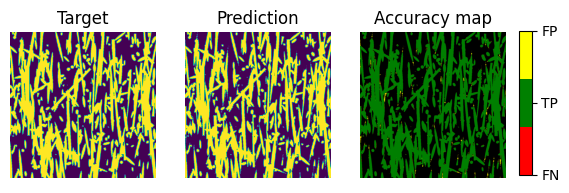

In [14]:
num_results = 6
for i in range(num_results):
    show_results(preds,ground_truth)

### Calculate accuracy of the network

In [15]:
tensor1 = torch.tensor([original_ac(preds,ground_truth)])
value1 = tensor1.item()
print(f'Original Accuracy: {value1*100}%')
tensor2 = torch.tensor([porus_ac(preds,ground_truth)])
value2 = tensor2.item()
print(f'Porus Accuracy: {value2*100}%')

Original Accuracy: 99.1675078868866%
Porus Accuracy: 99.41129088401794%


### Prediction for all the synthetic images and store them in prediction subfolder

In [16]:
"""prediction_path = path/'prediction'/'hyperstack'
for file in file_names:
    _ , prediction, _ = learner.predict(file)
    store_path = prediction_path/Path(file.stem + file.suffix) 
    tiff.imwrite(store_path,np.array(prediction,dtype=np.uint8))"""

"prediction_path = path/'prediction'/'hyperstack'\nfor file in file_names:\n    _ , prediction, _ = learner.predict(file)\n    store_path = prediction_path/Path(file.stem + file.suffix) \n    tiff.imwrite(store_path,np.array(prediction,dtype=np.uint8))"

### Prediction on real test data

#### Load the test data, predict the mask and store them in a folder

In [17]:
# Path to your test image
#test_path = Path('/home/susa03/post_project/post_dataset/test_data/ZrO2-P01-from-Repos/')
#test_image_path = test_path/'esb-corrected-3x3x3-toolip/'
test_path = Path('/home/susa03/post_project/post_dataset/test_data/2011-Oct-Porous-carbon-Opel2-Torben-Prill-GV_and_Segmented/')
test_image_path = test_path/'GV'
prediction_path = test_path/'results'/'hyperstack'
test_images = get_image_files(test_image_path)

for test in test_images:
    _, prediction, _ = learner.predict(test)
    store_path = prediction_path/Path(test.stem + test.suffix) 
    tiff.imwrite(store_path,np.array(prediction,dtype=np.uint8))

/home/susa03/post_project/unet_fastai/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [662] and output size of [850, 850]. Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

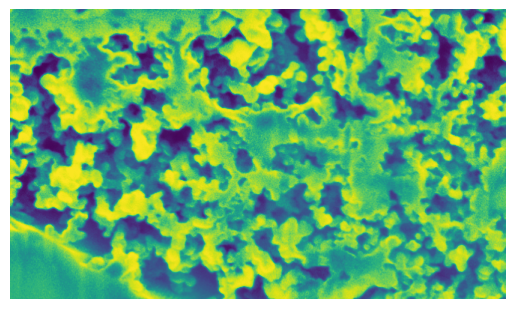

test image size: (387, 662)
process image size: (7, 387, 662)


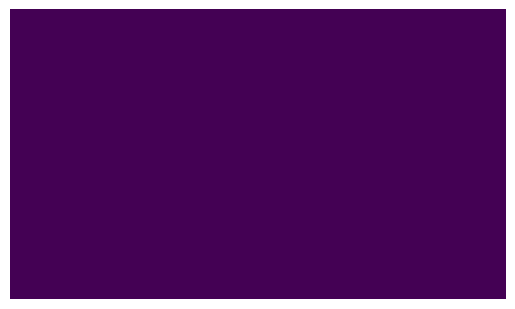

In [28]:
# Path to your tset image
#image_path = '/home/susa03/post_project/post_dataset/test_data/ZrO2-P01-from-Repos/esb-corrected-3x3x3-toolip/zirconiumP01_000.png'
image_path = '/home/susa03/post_project/post_dataset/test_data/2011-Oct-Porous-carbon-Opel2-Torben-Prill-GV_and_Segmented/GV/Gray_Value005.tif'
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
plt.imshow(image)
plt.axis('off')
plt.show()
print(f'test image size: {image.shape}')
process_image = torch.from_numpy(image)
process_image = np.expand_dims(process_image, axis=0)
process_image = np.repeat(process_image, 7, axis=0)
print(f'process image size: {process_image.shape}')
new_image = torch.from_numpy(process_image)

pred_class, pred_idx, pred_probs = learner.predict(new_image)
top = 0  
left = 0  
height = image.shape[0] 
width = image.shape[1]
pred_class = pred_class[top:top+height, left:left+width]
plt.imshow(pred_class)
plt.axis('off')
plt.show()